# MNIST TEST on AWS Sagemaker

* conda_tensorflow_p36

## 1. 생성한 S3 버킷의 이름을 추가하고 코드를 실행합니다. get_execution_role 함수는 노트북 인스턴스 생성 시점에 생성한 IAM 역할을 가져옵니다.

* bucket name = 'sagemaker-intelligentqa'

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sagemaker-intelligentqa'

## 2. MNIST 데이터 세트 다운로드

이 코드는 다음 작업을 수행합니다.

1. deeplearning.net 웹 사이트에서 MNIST 데이터 세트(mnist.pkl.gz)를 Amazon SageMaker 노트북 인스턴스로 다운로드합니다.

2. 파일의 압축을 해제하고 다음 3개의 데이터 세트를 노트북의 메모리에서 읽습니다.

    * train_set – 수기 숫자 이미지를 사용하여 모델을 교육합니다.

    * valid_set – 모델을 교육한 이후 데이터 세트에 있는 이미지를 사용하여 이를 검증합니다.

    * test_set – 이 연습에서는 이 데이터 세트를 사용하지 않습니다.

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 866 ms, sys: 259 ms, total: 1.13 s
Wall time: 10.5 s


## 3. 교육 데이터 세트 탐색

일반적으로 교육 데이터를 탐색하여 무엇을 정리하고 어떤 변형을 적용해야 모델 교육이 개선되는지 결정합니다. 이 연습에서는 MNIST 데이터 세트를 정리할 필요가 없습니다. train_set 데이터 세트의 이미지 중 하나만 표시됩니다.

train_set는 다음 데이터를 포함합니다.

    * train_set[0]은 이미지를 포함합니다.

    * train_set[1]은 레이블을 포함합니다.

코드는 matplotlib 라이브러리를 사용하여 교육 데이터 세트에서 31번째 이미지를 가져와 표시합니다.

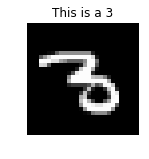

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## 4. 교육 데이터 세트 변형 및 S3로의 업로드

효율적인 모델 교육을 위해 데이터 세트를 numpy.array 형식에서 RecordIO protobuf 형식으로 변형합니다. RecordIO protobuf 형식이 Amazon SageMaker에서 제공하는 모든 알고리즘에 대해 더욱 효율적입니다.

    <중요> 이 단계와 후속 단계에서 Amazon SageMaker가 제공하는 상위 수준 Python 라이브러리 또는 하위 수준 AWS SDK for Python (Boto)을 사용할 수 있습니다. Amazon SageMaker를 처음 사용하는 경우 다상위 수준 Python 라이브러리의 코드 예제를 따르는 것이 좋습니다.

데이터 세트를 변형하려면 다음 옵션 중 하나를 선택합니다.

    * Amazon SageMaker가 제공하는 상위 수준 Python 라이브러리 사용

        상위 수준 Python 라이브러리를 사용하는 경우 이 단계를 건너뛰고 다음 단계로 이동합니다. 다음 단원에서 모델 교육에 대해 fit 메서드를 사용합니다. 모델 교육 작업을 시작하기 전에 필요한 변형을 수행하고 S3에 업로드합니다.

    * SDK for Python 사용

다음 코드는 우선 상위 수준 Python 라이브러리 함수인 write_numpy_to_dense_tensor를 사용하여 교육 데이터를 모델 교육에 효율적인 protobuf 형식으로 변형합니다. 그런 다음 코드는 SDK for Python 하위 수준 API를 사용하여 데이터를 S3로 업로드합니다.

In [4]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)
print('training data will be uploaded to: {}'.format(data_location))

# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to: s3://sagemaker-intelligentqa/kmeans_lowlevel_example/data
CPU times: user 8.77 s, sys: 391 ms, total: 9.16 s
Wall time: 9.49 s


## 5. Training 알고리즘 선택

### AWS Sagemaker 가 제공하는 범용 알고리즘

1. 이산적 범주에 맞는 답(예: 다음 질문에 대한 답):

 

    "과거 고객 응답을 기반으로 했을 때 이 특정 고객에게 메일을 보내야 하는가?" 이 질문에 대한 답은 "예" 또는 "아니요"라는 두 가지 범주로 나뉩니다. 이 경우 답을 사용하여 메일 캠페인의 수신자를 좁힙니다.

 

    "과거 고객 세그먼테이션을 기반으로 했을 때 이 고객이 어떤 세그먼트에 해당되는가?" 답은 "자녀를 출가시킨 부부", "교외 가족" 또는 "도시 거주 전문직"과 같은 범주에 해당될 수 있습니다. 이러한 세그먼트를 사용하여 메일의 수신자를 결정할 수 있습니다.

 

    이산적 분류 문제 유형의 경우 Amazon SageMaker는 Linear Learner 및 XGBoost 알고리즘 알고리즘을 제공합니다. 다음 하이퍼파라미터를 설정하여 이러한 알고리즘이 이산적 결과를 생산하도록 지시합니다.

 

    Linear Learner 알고리즘의 경우 predictor_type 하이퍼파라미터를 binary_classifier로 설정합니다.

 

    XGBoost 알고리즘의 경우 objective 하이퍼파라미터를 reg:logistic로 설정합니다.

 

2. 답이 정량적인 질문은 다음과 같습니다. "지난 메일링의 투자수익률(ROI)을 기반으로 이 고객 메일링의 ROI는 어떻게 되는가?" 이 경우 ROI를 사용하여 메일 캠페인의 대상 고객을 지정합니다. 정량적 분석 문제의 경우 Linear Learner 또는 XGBoost 알고리즘 알고리즘을 사용할 수 있습니다. 다음 하이퍼파라미터를 설정하여 이러한 알고리즘이 정량적 결과를 생산하도록 지시합니다.

 

    Linear Learner 알고리즘의 경우 predictor_type 하이퍼파라미터를 regressor로 설정합니다.

 

    XGBoost 알고리즘의 경우 objective 하이퍼파라미터를 reg:linear로 설정합니다.

 

3. 이산적 추천 형식의 답이 나오는 질문은 다음과 같습니다. "이전 메일링 응답을 기반으로 각 고객에 대한 추천 콘텐츠는 무엇인가?" 이 경우 고객에게 메일을 보낼 것인지 여부가 아닌 무엇을 메일로 보낼 것인가에 대한 추천을 찾고 있는 것입니다. 이 문제의 경우 Amazon SageMaker는 Factorization Machines 알고리즘을 제공합니다.

 

    이전 예제의 모든 질문들은 답을 포함한 예제 데이터를 보유한 것에 의존합니다. 답이 포함된 예제 데이터를 사용할 필요가 없거나 사용할 수 없을 때가 있습니다. 답을 통해 그룹이 식별되는 문제의 경우 그렇습니다. 예:

    "현재 및 잠재 고객을 속성 기반 10개의 그룹으로 그룹화하고자 합니다. 어떻게 그룹화해야 합니까? " 현재 고객의 비율이 가장 높은 그룹에 있는 고객에게 메일을 보내기로 할 수 있습니다. 다시 말해 동일한 속성 세트를 기반으로 현재 고객과 가장 유사한 잠재 고객입니다. 이러한 유형의 문제의 경우 Amazon SageMaker는 k-means 알고리즘을(를) 제공합니다.

 

    "이러한 고객을 차별화하는 속성은 무엇이고, 이러한 차원을 따라 각 고객에 대한 가치는 어떻게 되는가" 이러한 답변을 사용하여 현재 및 잠재 고객의 관점을 간소화하고 이러한 고객의 속성을 잘 이해할 수도 있습니다. 이러한 유형의 문제의 경우 Amazon SageMaker는 Principal Component Analysis(PCA) 알고리즘을 제공합니다.

### AWS Sagemaker 가 제공하는 특정 사례용 알고리즘

범용 알고리즘과 별개로 Amazon SageMaker는 특정 사용 사례에 맞춰진 알고리즘을 제공합니다. 다음이 포함됩니다.

    * Image Classification 알고리즘 – 이 알고리즘을 사용하여 이미지를 분류합니다. 답이 포함된 예제 데이터를 사용합니다(지도 알고리즘 참조).
    * Sequence2Sequence – 이 비지도 알고리즘은 신경망 머신 번역에 일반적으로 사용됩니다.
    * Latent Dirichlet Allocation(LDA) – 이 알고리즘은 여러 문서에서 주제를 결정하는 데 적합합니다. 비지도 알고리즘으로 교육 도중 답이 포함된 예제 데이터를 사용하지 않습니다.
    * Neural Topic Model(NTM) – 신경망 접근 방식을 사용하여 여러 문서에서 주제를 결정하는 또 다른 비지도 기법입니다.
    
<Amazon SageMaker 제공 알고리즘: 공통 정보>
    * Linear Learner
    * Factorization Machines
    * XGBoost 알고리즘
    * Image Classification 알고리즘
    * Sequence2Sequence
    * k-means 알고리즘
    * Principal Component Analysis(PCA)
    * Latent Dirichlet Allocation(LDA)
    * Neural Topic Model(NTM)
    * DeepAR Forecasting
    * BlazingText
    * Random Cut Forest

## 6. Training 작업 생성

모델을 교육하기 위해 Amazon SageMaker는 CreateTrainingJob API를 제공합니다. 이 API를 호출할 때 다음 정보를 제공합니다.

    * 교육 알고리즘 – 교육 코드가 포함된 도커 이미지의 레지스트리 경로를 지정합니다. Amazon SageMaker에서 제공하는 알고리즘의 레지스트리 경로는 Amazon SageMaker 제공 알고리즘: 공통 파라미터 단원을 참조하십시오. 다음 예제에서 상위 수준 Python 라이브러리를 사용할 때 이 경로를 명시적으로 지정할 필요가 없습니다. sagemaker.amazon.kmeans.KMeans 객체가 경로를 알고 있습니다.

    * 알고리즘별 하이퍼파라미터 – 모델의 최종 품질에 영향을 미치는 알고리즘별 하이퍼파라미터를 지정합니다. 자세한 정보는 k-means 하이퍼파라미터 단원을 참조하십시오.

    *입력 및 출력 구성 – 교육 데이터가 저장되고 Amazon SageMaker가 모델 교육 결과(모델 아티팩트)를 저장하는 S3 버킷을 제공합니다.

하위 수준 AWS SDK for Python은 해당 create_training_job 메서드를 제공하고 상위 수준 Python 라이브러리는 fit 메서드를 제공합니다.

### 모델을 교육하려면 다음 옵션 중 하나를 선택합니다.

### 6.1. Amazon SageMaker에서 제공하는 상위 수준 Python 라이브러리 사용.

이 Python 라이브러리는 KMeans 예측기를 제공합니다. 이는 sagemaker.amazon.kmeans.KMeans 모듈의 클래스입니다. 모델 교육을 시작하려면 fit 메서드를 호출합니다.

1. sagemaker.amazon.kmeans.KMeans 클래스의 인스턴스를 만듭니다.

    생성자에서 다음 파라미터를 지정합니다.

        * role – Amazon SageMaker에서 수임하여 사용자를 대신해 작업(예: S3 버킷에서 호출된 모델 아티팩트인 교육 결과 읽기 및 Amazon S3에 교육 결과 쓰기)을 수행하는 IAM 역할입니다.

        * output_path – Amazon SageMaker가 교육 결과를 저장하는 S3 위치.

        * train_instance_count 및 train_instance_type – 모델 교육에 사용할 ML 컴퓨팅 인스턴스의 유형과 수.

        * k – 생성할 클러스터의 수. 자세한 정보는 k-means 하이퍼파라미터 단원을 참조하십시오.

        * data_location – 상위 수준 라이브러리가 변형된 교육 데이터를 업로드하는 S3 위치.

In [5]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://sagemaker-intelligentqa/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://sagemaker-intelligentqa/kmeans_example/output


2. 모델 교육을 시작하려면 KMeans 예측기의 fit 메서드를 호출합니다.

이는 동기식 작업입니다. 메서드는 진행 로그를 표시하고 교육 완료까지 대기한 다음 반환합니다. 모델 교육에 대한 자세한 정보는 Amazon SageMaker를 사용한 모델 교육 단원을 참조하십시오.

이 예제의 모델 교육은 약 15분이 소요됩니다.

In [6]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-11-07-05-34-33-504


2018-11-07 05:34:33 Starting - Starting the training job...
2018-11-07 05:34:36 Starting - Launching requested ML instances......
2018-11-07 05:35:35 Starting - Preparing the instances for training........
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[11/07/2018 05:37:19 INFO 140243109685056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[11/07/2018 05:37:1


2018-11-07 05:37:28 Downloading - Downloading input data
2018-11-07 05:37:28 Training - Training image download completed. Training in progress.
2018-11-07 05:37:28 Uploading - Uploading generated training model
2018-11-07 05:37:28 Completed - Training job completed
Billable seconds: 44
CPU times: user 8.11 s, sys: 377 ms, total: 8.48 s
Wall time: 3min 21s


### 6.2 SDK for Python을 사용합니다.

하위 수준의 SDK for Python은 create_training_job 메서드를 제공합니다. 이는 기본 CreateTrainingJob Amazon SageMaker API로 매핑됩니다.

코드는 Waiter를 사용하여 교육이 완료될 때까지 대기한 다음 반환합니다.

이제 모델을 교육했습니다. 결과로 나온 아티팩트가 S3 버킷에 저장됩니다.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'kmeans-lowlevel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

images = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/kmeans:latest',
          'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:latest',
          'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/kmeans:latest',
          'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/kmeans:latest'}
image = images[boto3.Session().region_name]

output_location = 's3://{}/kmeans_example/output'.format(bucket)
print('training artifacts will be uploaded to: {}'.format(output_location))

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 2,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "k": "10",
        "feature_dim": "784",
        "mini_batch_size": "500"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": data_location,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}


sagemaker = boto3.client('sagemaker')

sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

## 7. Amazon SageMaker 호스팅 서비스로 모델 배포

Amazon SageMaker의 모델 배포는 3단계 프로세스입니다.

    1. Amazon SageMaker에서 모델 생성 – CreateModel 요청을 전송하여 정보(예: 모델 아티팩트가 포함된 S3 버킷의 위치 및 추론 코드를 포함하는 이미지의 레지스트리 경로)를 제공합니다. 다음 단계에서 엔드포인트 구성을 생성할 때 모델을 제공합니다.

    2. 엔드포인트 구성 생성 – CreateEndpointConfig 요청을 전송하여 호스팅에 대한 리소스 구성을 제공합니다. 여기에는 모델 배포를 시작할 ML 컴퓨팅 인스턴스의 유형 및 수가 포함됩니다. 다음 단계에서 이 엔드포인트 구성을 사용하여 CreateEndpoint API가 포함된 엔드포인트를 생성합니다.

    3. 엔드포인트 생성 – CreateEndpoint 요청을 전송하여 엔드포인트를 생성합니다. Amazon SageMaker가 ML 컴퓨팅 인스턴스를 시작하고 모델을 배포합니다. 그 응답으로 Amazon SageMaker는 엔드포인트를 반환합니다. 애플리케이션이 이 엔드포인트로 요청을 전송하여 모델로부터 추론을 가져올 수 있습니다.

하위 수준 AWS SDK for Python은 해당 메서드를 제공합니다. 하지만 상위 수준 Python 라이브러리는 이 모든 작업을 수행하는 deploy 메서드를 제공합니다.

모델을 배포하려면 다음 옵션 중 하나를 선택합니다.

### 7.1. Amazon SageMaker에서 제공하는 상위 수준 Python 라이브러리 사용.

    sagemaker.amazon.kmeans.KMeans 클래스는 모델 배포에 대해 deploy 메서드를 제공합니다. 모델 배포 프로세스의 모든 세 단계를 수행합니다.
    
    sagemaker.amazon.kmeans.KMeans 인스턴스는 k-means 추론 코드가 포함된 이미지의 레지스트리의 경로를 알고 있기 때문에 이를 제공할 필요가 없습니다.

    이는 동기식 작업입니다. 메서드는 배포 완료까지 대기한 다음 반환합니다. 다음을 반환합니다. kmeans_predictor.

In [7]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')


INFO:sagemaker:Creating model with name: kmeans-2018-11-07-05-41-04-647
INFO:sagemaker:Creating endpoint with name kmeans-2018-11-07-05-34-33-504


--------------------------------------------------------------!CPU times: user 263 ms, sys: 17.1 ms, total: 280 ms
Wall time: 5min 14s


### 7.2. SDK for Python을 사용합니다.

하위 수준 SDK for Python은 기본 Amazon SageMaker API로 매핑되는 메서드를 제공합니다. 모델을 배포하려면 세 가지를 호출합니다.

1. 모델 아티팩트 및 추론 코드를 포함하는 도커 이미지의 위치를 식별함으로써 Amazon SageMaker 모델을 생성합니다.

In [ ]:
%%time
import boto3
from time import gmtime, strftime


model_name=job_name
print(model_name)

info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': image,
    'ModelDataUrl': model_data
}

create_model_response = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

2. 모델을 배포하고자 하는 ML 컴퓨팅 인스턴스를 지정함으로써 Amazon SageMaker 엔드포인트 구성을 생성합니다.

In [ ]:
from time import gmtime, strftime

endpoint_config_name = 'KMeansEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

3. Amazon SageMaker 엔드포인트를 생성합니다. 이 코드는 Waiter를 사용하여 배포가 완료될 때까지 대기한 다음 반환합니다.

In [ ]:
%%time
import time

endpoint_name = 'KMeansEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

## 8. 모델 검증

이제 모델이 Amazon SageMaker에 배포되었습니다. 모델을 검증하려면 샘플 요청을 전송하고 추론을 가져옵니다. Amazon SageMaker 엔드포인트로 요청을 전송하려면 InvokeEndpoint API를 사용합니다.

모델을 검증하려면 다음 옵션 중 하나를 선택합니다.

### 8.1 Amazon SageMaker에서 제공하는 상위 수준 Python 라이브러리 사용.

이전 단계에서 deploy 호출로 인해 반환된 kmeans_predictor는 predict 메서드를 제공합니다. 모델로부터 추론을 얻으려면 이 메서드를 호출합니다.

1. valid_set 데이터 세트의 30번째 수기 숫자 이미지에 대한 추론을 얻습니다.

응답은 입력 이미지가 클러스터 3에 속한다고 표시합니다. 또한 해당 클러스터에 대한 평균 제곱 거리를 표시합니다.

    <참고>k-means 구현에서 클러스터 번호와 클러스터가 표시하는 숫자는 연결되지 않습니다. 예를 들어 알고리즘은 숫자 3의 수기 이미지를 클러스터 0에 그룹화하고, 숫자 4의 이미지를 클러스터 9에 그룹화할 수 있습니다.

In [8]:
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 8.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.61564302444458
    }
  }
}
]


2. 첫 100개의 이미지에 대한 추론을 얻습니다.

In [9]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 26.8 ms, sys: 4.04 ms, total: 30.8 ms
Wall time: 276 ms


결과를 시각화합니다.

이 코드는 valid_set 데이터 세트에서 처음 100개의 수기 숫자의 이미지를 가져오고 그에 대한 추론을 생성합니다. 결과는 유사한 이미지를 그룹화한 클러스터 세트입니다. 다음 시각화는 모델이 반환한 클러스터 중 4개를 보여줍니다.




Cluster 0:


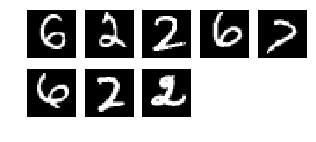




Cluster 1:


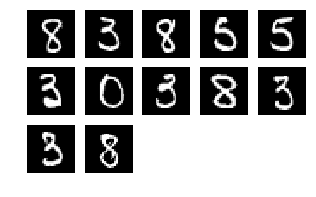




Cluster 2:


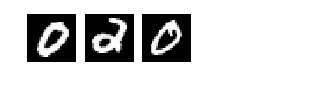




Cluster 3:


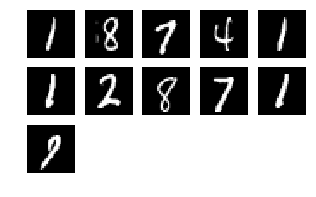




Cluster 4:


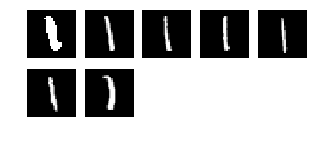




Cluster 5:


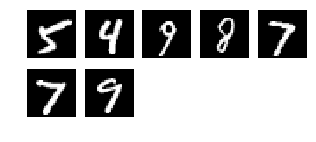




Cluster 6:


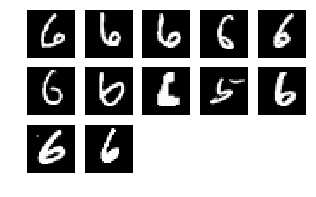




Cluster 7:


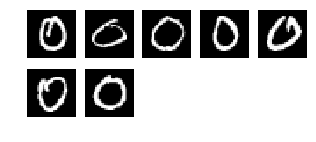




Cluster 8:


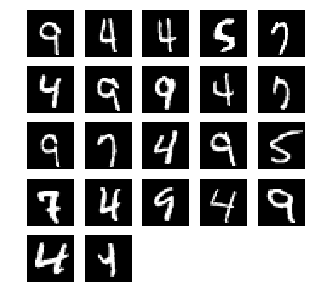




Cluster 9:


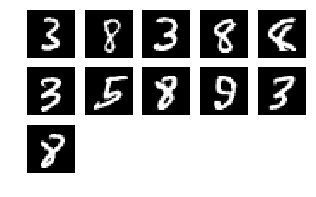

In [11]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

### 8.2. SDK for Python을 사용합니다.

1. 엔드포인트로 요청을 전송하려면 invoke_endpoint 메서드를 사용합니다.

train_set의 30번째 이미지를 입력으로 전송하는 요청을 전송합니다. 각 이미지는 28x28(총 784) 픽셀 이미지입니다. 요청은 이미지의 모든 784개 픽셀을 쉼표로 구분되는 값으로 전송합니다.

다음 예제 응답에서 추론은 클러스터 7(labels가 클러스터를 식별)에 속하는 이미지를 분류합니다. 추론은 또한 해당 클러스터에 대한 평균 제곱 거리를 표시합니다.

In [12]:
import json

# Simple function to create a csv from our numpy array
def np2csv(arr):
    csv = io.BytesIO()
    numpy.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

runtime = boto3.Session().client('sagemaker-runtime')

payload = np2csv(train_set[0][30:31])

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
print(result)

NameError: name 'endpoint_name' is not defined

2. 또 다른 테스트를 실행합니다. 다음 코드는 valid_set 검증 세트에서 처음 100개의 이미지를 가져오고 그에 대한 추론을 생성합니다. 이 테스트는 입력 이미지가 속하는 클러스터를 식별합니다. 그리고 결과를 시각적으로 제공합니다.

결과는 유사한 이미지를 그룹화한 클러스터 세트입니다. 다음 시각화는 모델이 반환한 클러스터 중 4개를 보여줍니다.

In [ ]:
%%time 

payload = np2csv(valid_set[0][0:100])
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
clusters = [p['closest_cluster'] for p in result['predictions']]

for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

3. 모델이 얼마나 정확한지 이해하려면 클러스터와 그 안에 있는 숫자를 검토하여 클러스터링된 모델이 숫자와 얼마나 유사한 모습인지 확인합니다. 모델을 개선하기 위해 교육 작업에 다음 변경 사항을 적용할 수 있습니다.

    * 모델 교육 파라미터 변경 – 예를 들어 epoch의 수를 늘리거나 extra_center_factor와 같은 하이퍼파라미터를 수정합니다. 자세한 정보는 k-means 하이퍼파라미터 단원을 참조하십시오.

    * 알고리즘 전환 고려 – MNIST 데이터 세트의 이미지에는 숫자를 식별하는 정보가 있으며, 이를 레이블이라고 합니다. 이와 유사하게 다른 문제에 대한 교육 데이터에 레이블을 지정할 수 있습니다. 그리고 레이블 정보와 지도 알고리즘(예: Amazon SageMaker가 제공하는 Linear Learner 알고리즘)을 사용할 수 있습니다. 자세한 정보는 Linear Learner 단원을 참조하십시오.

    * 전문 알고리즘 사용 – Linear Learner 알고리즘 대신 Amazon SageMaker에서 제공하는 이미지 분류 알고리즘과 같은 전문 알고리즘을 사용합니다. 자세한 정보는 Image Classification 알고리즘 단원을 참조하십시오.

    * 사용자 지정 알고리즘 사용 – Apache MXNet 또는 TensorFlow에 빌드된 사용자 지정 신경망 알고리즘 사용을 고려하십시오. 자세한 정보는 Amazon SageMaker를 통한 Apache MXNet 사용 및 Amazon SageMaker를 통한 TensorFlow 사용 단원을 참조하십시오.

## 9. 불필요한 비용이 발생하지 않도록 AWS Management 콘솔을 사용하여 이 연습에서 생성한 리소스를 삭제합니다.

<참고>이 설명서의 다른 연습을 시험할 계획인 경우 노트북 인스턴스, S3 버킷 및 IAM 역할과 같은 일부 리소스를 유지하고자 할 것입니다.

     * https://console.aws.amazon.com/sagemaker/에서 Amazon SageMaker 콘솔을 열고 다음 리소스를 삭제합니다.

        * 엔드포인트입니다. 이 또한 ML 컴퓨팅 리소스 또는 인스턴스를 삭제합니다.

        * 엔드포인트 구성.

        * 모델.

        * 노트북 인스턴스. 삭제하기 전에 인스턴스를 중지해야 합니다.

     * https://console.aws.amazon.com/s3/에서 Amazon S3 콘솔을 열고 모델 아티팩트 및 교육 데이터 세트 저장용으로 생성한 버킷을 삭제합니다.

     * https://console.aws.amazon.com/iam/에서 IAM 콘솔을 열고 IAM 역할을 삭제합니다. 권한 정책을 생성한 경우 역시 삭제할 수 있습니다.

     * https://console.aws.amazon.com/cloudwatch/에서 Amazon CloudWatch 콘솔을 열고 이름이 /aws/sagemaker/로 시작하는 모든 로그 그룹을 삭제합니다.

## 10. Amazon SageMaker 엔드포인트와 인터넷 경계 애플리케이션 통합 시 추가 고려 사항

프로덕션 환경에서 인터넷 경계 애플리케이션으로 엔드포인트에 추론 요청을 전송할 수 있습니다. 다음 상위 수준 예제는 모델 엔드포인트를 애플리케이션과 통합하는 방법을 보여줍니다.

    * AWS Lambda 서비스 주체가 맡을 수 있는 IAM 역할을 생성합니다. 해당 역할에 Amazon SageMaker InvokeEndpoint API를 호출할 권한을 부여합니다.

    * Amazon SageMaker InvokeEndpoint API를 호출하는 Lambda 함수를 생성합니다.

    * 모바일 애플리케이션에서 Lambda 함수를 호출합니다. Amazon Cognito를 자격 증명으로 사용하여 모바일 애플리케이션에서 Lambda 함수를 호출하는 방법에 대한 예제는 자습서: 모바일 애플리케이션 백엔드로 AWS Lambda 사용을 참조하십시오.